In [1]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Initalization
p = [] #price 
D = [] #demand


#Numerical experiment parameters
a = 0 #y-intercept or market size
b = 0 #coefficient of price
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling

n = 250 #sample size
cv = 0.5 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

##Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
Demand - price observation set is built by randomly choose a, b, p and u. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [3]:
# Demand - Price sampling generation function
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        # uniformly choose a, b, p in previously defined range
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp 

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar #choose sigma to get defined cv at mean price
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma) #normaly choose u
                D[i] = a - b*p[i] + u[i] #D = a -bp + u
 
        #check Arc price elasticity of obtained demand sampling
        #OLS regression 
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

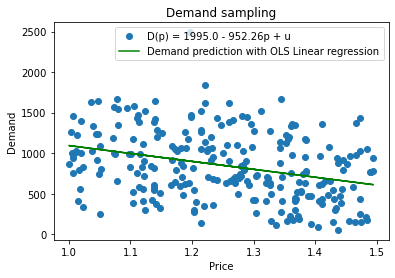

In [4]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, 'g-', label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [5]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta0
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta1

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit (co) = c
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit (cu) = p-c 
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i]) #shortage = D - min(D, q) >= 0
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i]) #waste = max(0, q-D)
        baseCostModel.addConstr(sales[i] <= D[i]) #sales = min(D,q)
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Using license file C:\Users\xuanson\gurobi.lic
Academic license - for non-commercial use only
Objective: 49385.09377872202
Estimation of a: 1585.179545198668
Estimation of b: -536.4757256997037

Ordering quantity - price function: q =  1585.0 + -536.48 * p


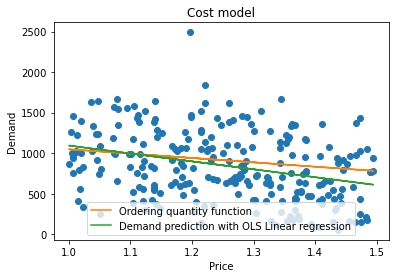

In [6]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: q = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [7]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta0
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta1

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable: = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize): #same as Cost model
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 67107.14785757966
Estimation of a: 3153.2564434202172
Estimation of b: -1426.6342586013823

Ordering quantity - price function: q =  3153.0 + -1426.63 * p


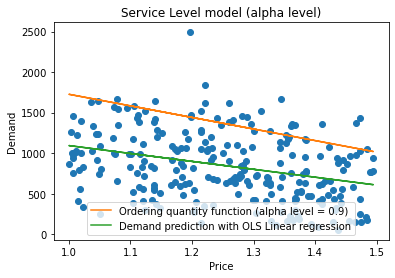

In [8]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: q = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.   
Huber et. al. (2019). *A data-driven newsvendor problem: From data to decision.* European Journal of Operational Research, 278(3), 904-915.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2*beta1}(-beta0 + beta1*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) to be profitable and the upper bound is -beta0/beta1 so that the expected demand is non-negative. Additionally, in case of beta1 greater than or equal to 0, the maximization problem is unbounded and the vendor will choose the price as high as possible (i.e. maximum value of price in historical data).   

In [9]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        pricingNV = gp.Model("Basic pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        pricingNV.addConstr(quantity == beta0 + beta1*price)

        pricingNV.setObjective(price * quantity - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0 #not print output
        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()

        return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [10]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = ubp)

print("Objective: ", objVal)
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)

Objective:  808.2077676700592
Optimal price from LP model: 1.7274009980891323
Optimal price from equation (1): 1.7274009980891325


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust.  
Using estimation error calculated from historical demand and ordering quantity-price function, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d_i(p) = beta0 + beta1 * p + error_i with error_i is the estimation error in each observation. Therefore, with historical data set of size n (observations), we can generate n samples of demands at each price.


In [11]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        M = beta0*100 #big M, demand <= beta0
        error = np.array([(D[i] - beta0 - beta1*p[i])[0] for i in range(sampleSize)]) #estimation errors of all demand observations

        pricingNV = gp.Model("Data-driven pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        sales = {}
        z = {}  # binary variable = 1 if beta0 + beta1*p + error > 0, = 0 otherwise 
                # ==> to ensure non-negativity: d_i(p) = max(0, beta0 + beta1*p + error_i)

        for t in range(sampleSize):
            sales[t] = pricingNV.addVar()
            z[t] = pricingNV.addVar(vtype = GRB.BINARY)

        for t in range(sampleSize):
            pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + error[t] ) #if beta0 + beta1*p + error > 0, z must equal to 1
            pricingNV.addConstr(sales[t] <= 0 + M*z[t] ) #if z = 0 (i.e. beta0 + beta1*p + error <= 0), sales = 0; otherwise, unbounded
            pricingNV.addConstr(sales[t] <= beta0 + beta1*price + error[t] + M*(1-z[t]) ) #if z = 1, sales <= beta0 + beta1*p + error: otherwise, unbounded
            pricingNV.addConstr(sales[t] <= quantity)

        pricingNV.setObjective( sum(price * sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0

        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()
        
        #if pricingNV.Status != 2: return 0,0,0

        return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [12]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = ubp)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  492.48010501519946
Optimal price: 1.6034773125938035
Optima ordering quantity: 858.3559492650359


In [13]:
# function to combine two steps into 1 flow

In [14]:
def DDNV_main(sampleSize, procurementCost, priceUpperBound, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost, nonStockOut)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Basic approach:', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Data-driven approach:', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [15]:
DDNV_main(sampleSize = n, procurementCost = c, priceUpperBound = ubp, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1585.179545198668 -536.4757256997037
Basic approach: 808.2077676700592 1.7274009980891323 658.4708411744082
Data-driven approach: 492.48010501519946 1.6034773125938035 858.3559492650359 



(808.2077676700592,
 1.7274009980891323,
 658.4708411744082,
 492.48010501519946,
 1.6034773125938035,
 858.3559492650359)

# ANALYSIS

## Sensitivity analysis

To generate out-of-sample demand observations, we will randomly draw 100,000 error terms and demands in the same way as we did previously (i.e. u ~ N(0,sigma) and D = a - b * p + u).This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [16]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [17]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [18]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [26]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 
                                                                  'Avg. opt. price (Basic)', 'Avg. opt. price (DD)',
                                                                  'Avg. opt. order qty (Basic)', 'Avg. opt. order qty (DD)' ])
#book-keeping variables
optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))

for j in range(testRep):
    print('Test run = ', j)
    # in each test run, draw a sampling set 
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], 
                                                             estimationModel = 'cost', nonStockOut = None, priceUpperBound = ubp)
        #save result of each test instance
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

#take the average of all test instances
for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optPriceDD[i,:]), 
                            np.mean(optQty[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 1788.5985269363377 -524.7560035849541
Basic approach: 1435.9639506731473 1.7542192130411487 868.0614632889212
Data-driven approach: 749.7897648414013 1.3423850180010086 1091.3919106892629 

Considering c = 0.2

Ordering quantity parameters: 1559.1911571794176 -427.9061229711939
Basic approach: 1268.6931296609885 1.9218846067836943 736.8049662925895
Data-driven approach: 670.6140790962143 1.544582627607533 925.6490173475822 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1504.2404795069222 -454.21689669188703
Basic approach: 1029.9907034283533 1.805861429267026 683.9877052496779
Data-driven approach: 571.6705134809168 1.538308878361997 851.6151979548509 

Considering c = 0.4

Ordering quantity parameters: 1272.2334744834384 -329.68088714794504
Basic approach: 986.1228947791024 2.1294923122317986 570.1805598121302
Data-driven approach: 561.7325070483272 1.8956850026439414 767.0484947825576 

Considering

Data-driven approach: 513.3482709736342 2.11954518146506 759.2422567373278 

Considering c = 0.8

Ordering quantity parameters: 1023.2430532522711 -223.86137159062486
Basic approach: 795.8004281098363 2.6854390777241264 422.07697798988556
Data-driven approach: 798.5631341214113 3.2332558944586927 771.4624108903672 

Considering c = 0.9

Ordering quantity parameters: 444.1183979651249 141.76568373286565
Basic approach: 394.06015413865407 1.5 656.7669235644235
Data-driven approach: 394.06015413865407 1.5 656.7669235644235 

Test run =  4
Considering c = 0.1

Ordering quantity parameters: 1962.7402616760298 -813.943926188762
Basic approach: 1087.1333285794365 1.2556974679241293 940.6729345285769
Data-driven approach: 650.8237502505859 1.013278240991108 1105.4546712005954 

Considering c = 0.2

Ordering quantity parameters: 1395.7037201743694 -471.3679376575698
Basic approach: 898.3005921911162 1.5804822397448393 650.7150663214277
Data-driven approach: 519.3142907774669 1.3007719037178227 

Data-driven approach: 631.1355948197885 1.7301974185653117 991.5810811645769 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1548.4720993126007 -418.19359792692813
Basic approach: 1006.5023874226702 2.151381880292639 648.7779702782221
Data-driven approach: 656.5859026373137 2.1525433097129536 906.2604530247993 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1183.4864992955395 -223.51542037249925
Basic approach: 1179.7640147650245 2.9974381439168765 513.5128525173949
Data-driven approach: 1038.0871578467315 3.443057528342239 926.2203412890676 

Considering c = 0.8

Ordering quantity parameters: 1012.3512116900303 -182.82522597895442
Basic approach: 1025.7250740437585 3.1686310963634887 433.04551545343355
Data-driven approach: 1186.3382769376824 4.076622454853468 920.0710914203679 

Considering c = 0.9

Ordering quantity parameters: 540.007701996293 100.00287757152178
Basic approach: 414.0072110121455 1.5 690.0120183535757
Data-driven approach: 414

Data-driven approach: 373.6581191284809 1.1127551415239176 661.6253354223094 

Considering c = 0.4

Ordering quantity parameters: 1337.9943352383925 -640.1205307461333
Basic approach: 457.1824198406391 1.245111249344563 540.9730614699696
Data-driven approach: 311.7280602639482 1.1483531164401501 595.5770583002375 

Considering c = 0.5

Ordering quantity parameters: 1218.0117744400086 -570.7261528101807
Basic approach: 381.0205602386019 1.3170719822831651 466.3243490174591
Data-driven approach: 252.25734541117043 1.227764895036383 517.2007897449112 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1184.0790778037351 -574.6713238816154
Basic approach: 306.42936698383176 1.3302228670519676 419.638141737383
Data-driven approach: 203.29368075735275 1.2637324245202426 465.51235675253844 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1177.8431879396585 -601.9397469037817
Basic approach: 237.6774878900644 1.3283729966314497 378.24268255350563
Data-driven 

Data-driven approach: 738.8726223698895 1.5033993407893615 1016.964395141928 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1905.7109524036773 -693.4239967864872
Basic approach: 1039.0937362296777 1.5241310952860392 848.8418766838657
Data-driven approach: 607.0281919416927 1.3054916335623503 1007.1943473984674 

Considering c = 0.4

Ordering quantity parameters: 1773.4802626861642 -674.0819391322988
Basic approach: 838.7545834440243 1.5154782525170816 751.9237435166225
Data-driven approach: 512.2708897913084 1.3615027612011474 916.0537540030576 

Considering c = 0.5

Ordering quantity parameters: 1717.0147618924161 -675.785069238961
Basic approach: 703.6179860780976 1.5203852452866717 689.5611136364678
Data-driven approach: 427.54713228793344 1.3879665357993574 802.8875034625735 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1634.2093879099123 -691.1488400963018
Basic approach: 537.9554839126564 1.4822412866107162 609.7600419260657
Data-driven

Data-driven approach: 554.3218502454595 0.9453854585070794 932.5207951516754 

Considering c = 0.2

Ordering quantity parameters: 1777.8174983160593 -917.5092244061868
Basic approach: 692.5931465245995 1.0688281332902483 797.1578267174111
Data-driven approach: 492.06726901517305 0.9597193201451001 874.624922857998 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1711.5212247797876 -894.0255092905098
Basic approach: 582.5208692175097 1.1071993231703392 721.6567859963174
Data-driven approach: 404.46541426359954 1.0066470215466998 779.3090424665529 

Considering c = 0.4

Ordering quantity parameters: 1544.0294049542617 -802.8982361057659
Basic approach: 465.62915446065665 1.161534934018006 611.4350552559775
Data-driven approach: 319.4594983733972 1.0752944565365137 657.375589969105 

Considering c = 0.5

Ordering quantity parameters: 1419.4685748227282 -733.5129098470501
Basic approach: 377.7039205805367 1.2175825440609571 526.3560599496014
Data-driven approach: 251.39

Data-driven approach: 30105.856204613134 83.0443506638246 1189.2892993790763 

Test run =  23
Considering c = 0.1

Ordering quantity parameters: 2347.175650955368 -960.744939096549
Basic approach: 1318.6268834311547 1.271539430206403 1125.5505785228568
Data-driven approach: 765.6957604859954 1.0227772635009165 1335.3809686574273 

Considering c = 0.2

Ordering quantity parameters: 1810.4001446301563 -656.5562975960496
Basic approach: 1073.5330292413619 1.4787089936223687 839.5444425554732
Data-driven approach: 611.8605586917209 1.2169691850725024 1011.3913621904861 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1693.134493054474 -641.2066645956966
Basic approach: 878.1560618969628 1.470272064017032 750.3862468378826
Data-driven approach: 517.3624725996856 1.2658110812531522 882.0220018987079 

Considering c = 0.4

Ordering quantity parameters: 1649.7646496948846 -664.1131042775677
Basic approach: 721.1823269327015 1.4420810845838705 692.0597039919288
Data-driven a

Data-driven approach: 420.4977607315146 2.006016110644216 671.8209931722737 

Considering c = 0.8

Ordering quantity parameters: 1086.0228162761346 -328.1225864958789
Basic approach: 516.7222838077616 2.0549040830655745 411.7623735397158
Data-driven approach: 420.225963235092 2.334847555473135 622.6608822760461 

Considering c = 0.9

Ordering quantity parameters: 647.7505379892357 -73.92493980131403
Basic approach: 1142.4238950055483 4.831136729567698 290.6090460840265
Data-driven approach: 2016.9221601081401 7.397700615521172 806.2951987123956 

Test run =  27
Considering c = 0.1

Ordering quantity parameters: 1548.2033630761434 -506.0349934409051
Basic approach: 1108.0287830490615 1.5797394282446426 748.7999318660266
Data-driven approach: 572.1002596683426 1.204631886566169 938.6174742589288 

Considering c = 0.2

Ordering quantity parameters: 1649.8026641802714 -675.4703306569262
Basic approach: 849.1646608563357 1.321225114784658 757.3542990244432
Data-driven approach: 496.49244313

Data-driven approach: 454.6073367419403 1.6307366266754741 763.5097040465876 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1472.5803581905473 -544.1917295030398
Basic approach: 603.4020950788739 1.6529977380723144 573.0326602443618
Data-driven approach: 364.47634932426064 1.585192655858743 700.407122872687 

Considering c = 0.7000000000000001

Ordering quantity parameters: 964.694279848427 -233.58781798260472
Basic approach: 686.9941850925028 2.4149498937488847 400.5914036303019
Data-driven approach: 580.6885591083411 2.70177843482419 651.9630630650864 

Considering c = 0.8

Ordering quantity parameters: 769.838423116973 -137.6788055237184
Basic approach: 790.2414446073226 3.1957768088870817 329.8476893489992
Data-driven approach: 913.2692443443849 4.0300468588238205 686.2844228651816 

Considering c = 0.9

Ordering quantity parameters: 613.2967786411418 -62.43440113125453
Basic approach: 1242.771959071601 5.361529281363817 278.5529088115064
Data-driven approach: 

Data-driven approach: 418.039748212152 1.2025834491767604 816.6098569524958 

Considering c = 0.5

Ordering quantity parameters: 1549.1703771715024 -656.2055648716845
Basic approach: 568.0407751514132 1.430400213060087 610.5337973678302
Data-driven approach: 340.8911816302539 1.3122772202614177 706.0600437851617 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1523.9110868197831 -686.8484688345746
Basic approach: 449.91863400872904 1.4093502831894733 555.9010027595192
Data-driven approach: 272.31795820491425 1.3230307828420884 632.9582424043676 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1439.4928162708998 -681.6568863460304
Basic approach: 339.6447734228895 1.4058778507961616 481.1664979143393
Data-driven approach: 212.71582653842466 1.3676255837270106 563.905914350181 

Considering c = 0.8

Ordering quantity parameters: 1117.6603740138967 -490.86773948405084
Basic approach: 267.6769745627968 1.5384536852927684 362.48309121332807
Data-driven 

Data-driven approach: 546.5314189399373 0.9490190644572759 993.045238562986 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1579.5282305717371 -746.2739583129517
Basic approach: 615.6506513597118 1.208276396340068 677.8230215389258
Data-driven approach: 408.0215338169379 1.0842530639761279 750.7595267036049 

Considering c = 0.4

Ordering quantity parameters: 1570.4973343533748 -767.5477267541928
Basic approach: 519.9602632307771 1.2230616804734062 631.7391218258489
Data-driven approach: 337.69814535684776 1.1196725563580376 698.8786762026848 

Considering c = 0.5

Ordering quantity parameters: 1526.4345872803055 -778.4849931234932
Basic approach: 415.29569054509136 1.2303879334628118 568.5960453592795
Data-driven approach: 273.06279419937863 1.1486876818745164 613.7042959348842 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1346.6926054991004 -673.7633367812389
Basic approach: 329.5604455067411 1.2993810378081998 471.21730171517845
Data-driven

Data-driven approach: 180.6801311250016 1.9108680407093441 367.91698213669247 

Test run =  42
Considering c = 0.1

Ordering quantity parameters: 2808.0771549996903 -647.0975337100832
Basic approach: 2907.6237770405332 2.2197479967971745 1371.6837008143407
Data-driven approach: 1449.9097591128036 1.6613345099842645 1806.6332987812814 

Considering c = 0.2

Ordering quantity parameters: 2840.766122562287 -857.3602129729651
Basic approach: 2077.6363241313757 1.7566934641810021 1334.6470399838472
Data-driven approach: 1193.9936963446046 1.4489360716384168 1663.236414106139 

Considering c = 0.30000000000000004

Ordering quantity parameters: 2457.4308178671254 -643.1104728037411
Basic approach: 1993.4171272204085 2.060582179725335 1132.2488380130017
Data-driven approach: 1131.3094944736092 1.7566890208052979 1436.1740817216228 

Considering c = 0.4

Ordering quantity parameters: 2386.51562129438 -687.0840073046453
Basic approach: 1622.509365416174 1.93669856663992 1055.841009186261
Data-dr

Data-driven approach: 582.9738470165961 2.6745317426941213 641.4966480259204 

Considering c = 0.8

Ordering quantity parameters: 825.1514970894445 -169.88878472238312
Basic approach: 699.0638394892826 2.8285049140760896 344.6202346557691
Data-driven approach: 722.8968868924305 3.3845558395088697 632.9249827906299 

Considering c = 0.9

Ordering quantity parameters: 668.719780764465 -99.13925516394556
Basic approach: 846.8235370539187 3.8226286305995036 289.747225558457
Data-driven approach: 1229.9219684736083 5.308550859302408 698.5156246522353 

Test run =  46
Considering c = 0.1

Ordering quantity parameters: 1484.4720059494502 -730.1265134871055
Basic approach: 682.1480499917226 1.0665854674004154 705.7296773003701
Data-driven approach: 456.0295227965307 0.90886179197819 808.7050086549461 

Considering c = 0.2

Ordering quantity parameters: 1404.2840372141554 -711.2732917982532
Basic approach: 559.8123012130646 1.0871620749767086 631.0146894272525
Data-driven approach: 376.28364025

Data-driven approach: 216.19675718909207 1.1003915910166733 514.2044453096734 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1253.570630980431 -691.3087467402971
Basic approach: 254.43078868341772 1.2066648128577473 419.3926914681262
Data-driven approach: 166.20295757614298 1.1485246197984031 450.6625580594216 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1203.6952748259812 -682.3954435846955
Basic approach: 193.10753591782668 1.2319631535806004 363.0092321583473
Data-driven approach: 124.22227289962684 1.184117748166324 381.42946200481583 

Considering c = 0.8

Ordering quantity parameters: 1136.698481490498 -663.1766315270579
Basic approach: 138.5100533081873 1.2570103555014362 303.0785881344258
Data-driven approach: 88.54959408628486 1.226719318829074 323.1661554795805 

Considering c = 0.9

Ordering quantity parameters: 1044.7973791452139 -624.2616086596846
Basic approach: 93.41124934607575 1.2868265520832178 241.48096567574876
Data-driven

In [27]:
resultCost

,Procurement cost,Avg. opt. price (Basic),Avg. opt. price (DD),Avg. opt. order qty (Basic),Avg. opt. order qty (DD)
0,0.1,1.52007,1.19019,990.126,1204.52
1,0.2,1.47051,1.22811,862.146,1020.66
2,0.3,1.53605,1.33424,753.892,891.082
3,0.4,1.52333,1.37464,671.019,793.23
4,0.5,1.57269,1.46354,593.211,704.276
5,0.6,1.64056,1.59082,514.373,629.007
6,0.7,1.86045,1.92675,431.253,567.811
7,0.8,2.19638,2.5259,358.457,534.729
8,0.9,3.30219,4.85938,314.509,526.564


**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. This trend can be seen in both approaches: basic and data-driven.

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution. In addition, we will run the experiment with different sample sizes and different coefficients of variation.

In [22]:
testRep = 50
results = pd.DataFrame(index = range(9), columns = ["Sample size", 'cv', 'Avg Out-of-sample profit (Basic)', 
                                                    'Avg Out-of-sample profit (DD)'])
idx=0
for i in [100,200,500]: #run experiment with different sampling sizes
    for k in [0.3, 0.5, 0.8]: #run experiment with different coefficient of variation
        print(i, k)
        
        resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 
                                                                   'Out-of-sample profit (Data-driven)'])

        for j in range(testRep):
            print('Test run = ', j)
            #random generate demands
            samplingDemand(sampleSize=i, coefVar=k)
            testU = outOfSampleError(testSize = 100000)

            optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=i, procurementCost=c, 
                                                                 estimationModel = 'cost', nonStockOut = None, priceUpperBound = ubp)

            #Basic approach
            testD = outOfSampleDemand(testU, chosenPrice = optP)
            testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)

            #Data-driven approach
            testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
            testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)

            #save result in each run
            resultDD.iloc[j,:] = [testV, testVDD]

        print(resultDD)
        print('\n\nOut-of-sample profit from Basic approach')
        print('Average:', np.mean(resultDD.iloc[:,0]) )
        print('Out-of-sample profit from Data-driven approach')
        print('Average:', np.mean(resultDD.iloc[:,1]) )
        
        results.iloc[idx,:] = [i, k, np.mean(resultDD.iloc[:,0]), np.mean(resultDD.iloc[:,1])]
        idx+=1
        
print(results)

100 0.3
Test run =  0

Ordering quantity parameters: 2167.9689372943335 -1042.256264414666
Basic approach: 650.532102779616 1.2900364148983412 823.4204025435005
Data-driven approach: 492.053649062936 1.228483601828343 876.3138159872351 

Test run =  1

Ordering quantity parameters: 1354.4878857406106 -694.6200559679833
Basic approach: 365.0942801174923 1.2249847230174435 503.58892887830945
Data-driven approach: 268.58468979297186 1.1662641121836677 544.2816521286202 

Test run =  2

Ordering quantity parameters: 1507.366003378016 -475.8183565391156
Basic approach: 846.7099937757282 1.8339721005531444 634.7284125542293
Data-driven approach: 640.8691555670156 1.74377262742147 787.3851704376784 

Test run =  3

Ordering quantity parameters: 1831.7328224469231 -866.9690788778964
Basic approach: 563.7739305146848 1.306400318692856 699.1241415039874
Data-driven approach: 427.151124201505 1.2447734203680128 752.5585263417886 

Test run =  4

Ordering quantity parameters: 1677.0758478626965 -7

Ordering quantity parameters: 1320.19840909025 -356.86566451172706
Basic approach: 913.2488510961246 2.0997134081203632 570.8827884171933
Data-driven approach: 651.2193216049004 1.9836941533874441 710.5996356757946 

Test run =  36

Ordering quantity parameters: 1772.0820392273233 -848.0842135148965
Basic approach: 535.6813717832122 1.2947559399100859 674.0199662349376
Data-driven approach: 404.9350341888775 1.2336051179545646 725.9133143043584 

Test run =  37

Ordering quantity parameters: 1427.526044482969 -504.6994380537054
Basic approach: 684.0900206062753 1.664233835872693 587.5881627280583
Data-driven approach: 501.4030739042142 1.567016474416363 682.0269184471022 

Test run =  38

Ordering quantity parameters: 1479.0936403177936 -527.0412750865803
Basic approach: 700.9022798221476 1.6532047490728443 607.7865013872517
Data-driven approach: 498.75012975307715 1.5537425376812972 706.816365609702 

Test run =  39

Ordering quantity parameters: 1294.7104503842966 -458.19781145899753

Data-driven approach: 440.5194768727933 1.8031543006454105 642.8606249641911 

Test run =  6

Ordering quantity parameters: 1455.9193615677675 -885.9068632814353
Basic approach: 289.5620346004142 1.07171130053953 506.48296496352515
Data-driven approach: 211.09146433435384 1.0186750515988066 514.6378746317268 

Test run =  7

Ordering quantity parameters: 1672.5398800573741 -675.5520983033016
Basic approach: 659.310543468345 1.4879059174400315 667.3819154528618
Data-driven approach: 411.1324901851544 1.370277484743481 785.2375886015171 

Test run =  8

Ordering quantity parameters: 1968.7152430657352 -1158.3415659603793
Basic approach: 416.72375905667747 1.0997991011111978 694.7722300427728
Data-driven approach: 307.99570847449115 1.0479940570347224 712.7490179098525 

Test run =  9

Ordering quantity parameters: 1519.2441431052612 -471.21141862641724
Basic approach: 874.1976337878466 1.8620621053006978 641.8192168960262
Data-driven approach: 517.2999877101723 1.7119171563978621 780.646


Ordering quantity parameters: 1673.4872235382954 -624.5614292464068
Basic approach: 741.6737061991221 1.5897298849830659 680.6032544575461
Data-driven approach: 440.610302411848 1.4949063859202798 813.326708151531 

Test run =  42

Ordering quantity parameters: 1911.209991057293 -752.8332076334651
Basic approach: 782.2419088426516 1.5193449038102282 767.3966936202801
Data-driven approach: 472.05364097691097 1.4026184909708963 901.9183850821522 

Test run =  43

Ordering quantity parameters: 1368.583463246633 -437.73131979365957
Basic approach: 754.9442817814585 1.8132688379389486 574.8589016749017
Data-driven approach: 448.598837743532 1.6967189114588384 703.6909815297847 

Test run =  44

Ordering quantity parameters: 1843.6888385031118 -784.7608617269609
Basic approach: 670.9993441346974 1.4246819498909846 725.6542038198158
Data-driven approach: 394.89537904001946 1.2987239378451534 836.2408650018447 

Test run =  45

Ordering quantity parameters: 1491.6222131077877 -655.13519399265

Data-driven approach: 413.5973284377673 2.0884712062678443 654.7502277546556 

Test run =  12

Ordering quantity parameters: 941.3771560971845 -180.74457658806668
Basic approach: 1001.7026495284525 2.8541643236761356 425.50243390157567
Data-driven approach: 571.957141712396 2.996136474063481 649.5754973347475 

Test run =  13

Ordering quantity parameters: 1520.7703512226597 -406.95505757709554
Basic approach: 1066.002466198428 2.118474568514924 658.6464112170561
Data-driven approach: 625.7554846559998 2.146259712257441 987.2817239650564 

Test run =  14

Ordering quantity parameters: 1004.1975082635195 -277.82699457999234
Basic approach: 673.7254066854696 2.057235308040575 432.6420054867617
Data-driven approach: 385.9549839764134 1.901744335752772 547.3475157907733 

Test run =  15

Ordering quantity parameters: 1057.922687718675 -119.44336436601921
Basic approach: 2085.5182134669585 4.678553621768404 499.1005027678327
Data-driven approach: 1461.6331291960869 4.9664732876062665 1023.6


Ordering quantity parameters: 1376.3093902327 -428.8810377640514
Basic approach: 786.8961059991873 1.8545351380047204 580.9344356753372
Data-driven approach: 428.5063270196452 1.8059850954334236 774.1171383455103 

Test run =  48

Ordering quantity parameters: 1322.6033631953217 -739.1900346753409
Basic approach: 307.16895002285764 1.144630136468372 476.5041729288257
Data-driven approach: 211.0648605539128 1.080210502528548 506.1211103081013 

Test run =  49

Ordering quantity parameters: 2774.9294699509323 -1134.4809374334427
Basic approach: 1074.0353948116574 1.4729951947137634 1103.8445006171055
Data-driven approach: 565.4527316970816 1.3495814765227607 1349.8866569154393 

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                      -227.044                            -468.18
1                       208.737                            228.545
2                       152.562                            144.056
3                       54.2914              

Data-driven approach: 328.5960436307766 1.2889355844757664 547.8284382003001 

Test run =  18

Ordering quantity parameters: 1635.0865817689967 -829.8563109858104
Basic approach: 448.5073396152085 1.2351624673593369 610.0792131380458
Data-driven approach: 344.57155185185314 1.1808275193307936 646.7193304089619 

Test run =  19

Ordering quantity parameters: 1411.1101521833625 -449.01261972034405
Basic approach: 783.9582991526571 1.8213479869031697 593.3019211615954
Data-driven approach: 601.4280350001326 1.7434619340672528 731.9120929216559 

Test run =  20

Ordering quantity parameters: 1711.713513753784 -578.6962402322338
Basic approach: 874.0005431027797 1.728939549587245 711.1826968188336
Data-driven approach: 643.5674512949049 1.6381855847466205 841.4285486028709 

Test run =  21

Ordering quantity parameters: 1645.4275115214323 -742.4690095260513
Basic approach: 546.6786484153795 1.3580782432735992 637.0965033792033
Data-driven approach: 401.17899011571706 1.287460435916161 703.1

Data-driven approach: 867.8736426886478 2.4662135984401043 1086.430306470396 

Test run =  1

Ordering quantity parameters: 1759.9601733187508 -665.2285443346392
Basic approach: 765.6452578908475 1.5728237034529695 713.6729505757157
Data-driven approach: 489.6817287873831 1.4609396188140338 832.1274917252795 

Test run =  2

Ordering quantity parameters: 1565.178058777589 -515.885476864489
Basic approach: 828.1218697726949 1.766982090958072 653.6176601726723
Data-driven approach: 523.0873800743238 1.6632647768801336 809.9168915965502 

Test run =  3

Ordering quantity parameters: 1577.9496271680782 -680.8188802965439
Basic approach: 562.3763378234826 1.408861536331639 618.7700935099032
Data-driven approach: 369.5381578385229 1.311494777377686 698.9192190266217 

Test run =  4

Ordering quantity parameters: 1607.7068012974357 -815.0215469031714
Basic approach: 441.8504365713694 1.2362971153377613 600.098013922925
Data-driven approach: 306.5782035531059 1.1644333576743748 647.15251756950

Data-driven approach: 1149.1637904712206 3.532201852915647 846.2808743090968 

Test run =  37

Ordering quantity parameters: 1401.8767328333959 -600.8450623071901
Basic approach: 504.7896015569742 1.416587545423372 550.7271008399003
Data-driven approach: 297.4392456371645 1.2968739444455446 626.5044005248011 

Test run =  38

Ordering quantity parameters: 1438.1274470007825 -442.658042729223
Basic approach: 836.197620798882 1.8744225882963286 608.3992128180855
Data-driven approach: 537.8976652992772 1.7333790184295634 753.8877954157919 

Test run =  39

Ordering quantity parameters: 1297.3836142391872 -568.0942091211293
Basic approach: 451.8840648966675 1.3918736482513225 506.66825483931143
Data-driven approach: 300.38336003562154 1.2989151658191753 568.602030521965 

Test run =  40

Ordering quantity parameters: 1651.7106923258916 -682.6300417398436
Basic approach: 628.8680217596394 1.4598139485013855 655.197835727985
Data-driven approach: 398.8814235739302 1.3560344687087493 761.6613

Data-driven approach: 314.92032614188975 1.354930106976723 707.262162464812 

Test run =  7

Ordering quantity parameters: 851.4490405252646 -193.512810186318
Basic approach: 735.8181784284363 2.4499810754271834 377.34631771605285
Data-driven approach: 492.28078134989806 2.512173464958519 655.634118454218 

Test run =  8

Ordering quantity parameters: 1997.61021546096 -686.9575032214076
Basic approach: 995.7496958940433 1.7039547250691622 827.0657319251283
Data-driven approach: 564.196899824189 1.6366228363847968 1096.169441380193 

Test run =  9

Ordering quantity parameters: 1224.6658996764575 -496.7212805888585
Basic approach: 479.7317916231778 1.4827495796280634 488.1526296910141
Data-driven approach: 257.4004119992328 1.342814753174392 573.4630138628884 

Test run =  10

Ordering quantity parameters: 866.6443250654778 -197.8595256160941
Basic approach: 744.7021406562209 2.440049537334441 383.85728112871544
Data-driven approach: 462.43122081576377 2.510738618863004 624.342236669619

Data-driven approach: 264.00860842121557 1.4190728719686543 581.834622020803 

Test run =  43

Ordering quantity parameters: 1933.307406385065 -896.697561094677
Basic approach: 614.7842416784061 1.3280153143412747 742.4793129188631
Data-driven approach: 344.5171662704835 1.214302402819201 840.2746409250936 

Test run =  44

Ordering quantity parameters: 1757.1883728731214 -583.1573225913654
Basic approach: 920.8543490138397 1.7566160577944347 732.8048557887192
Data-driven approach: 478.8345354661052 1.6708861071801488 915.1052815753068 

Test run =  45

Ordering quantity parameters: 2146.981274383383 -1127.1880383123798
Basic approach: 556.0552265462169 1.202361629740958 791.6936276135966
Data-driven approach: 337.89017540212603 1.1109472785930639 839.4980281102453 

Test run =  46

Ordering quantity parameters: 1038.6365952204817 -316.1510534093781
Basic approach: 613.1466169603735 1.892627130322369 440.2805342578963
Data-driven approach: 360.21754274577955 1.8298080078800294 649.6473

Data-driven approach: 494.9636217943096 1.4469483327296702 760.8105644062896 

Test run =  13

Ordering quantity parameters: 1423.6108312774163 -849.8495223584656
Basic approach: 293.3971957295114 1.087566412537759 499.34303504909184
Data-driven approach: 236.18589722570107 1.0509094328033566 511.6856589106222 

Test run =  14

Ordering quantity parameters: 1638.8825862746114 -866.456583944069
Basic approach: 419.4100155467446 1.195738434356685 602.8271471512887
Data-driven approach: 326.2433901700742 1.147289788234031 635.2894957650409 

Test run =  15

Ordering quantity parameters: 1580.7336124911405 -794.5617002667019
Basic approach: 440.67076234047397 1.2447204930470175 591.7263811788948
Data-driven approach: 329.5629963518044 1.1858356947783966 634.6112527947699 

Test run =  16

Ordering quantity parameters: 1720.4950098885477 -907.2394360593335
Basic approach: 442.26830904029384 1.198203385735553 633.4376459294406
Data-driven approach: 338.5168229428946 1.1459942964637495 668.49


Ordering quantity parameters: 1828.330238409001 -867.1439544015593
Basic approach: 560.8499596099712 1.304225327368386 697.3791306041105
Data-driven approach: 432.1311574471328 1.245800172752877 748.0421502139161 

Test run =  49

Ordering quantity parameters: 1392.4131289770314 -866.4553908097054
Basic approach: 265.4599145367631 1.0535111465322045 479.5927167860893
Data-driven approach: 221.50220691925242 1.0235371473932147 486.2072651984646 

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                       311.601                            319.447
1                       477.088                            485.379
2                       394.055                            418.885
3                       712.393                             715.96
4                       372.485                            389.883
5                       259.966                            262.611
6                        349.51                            359.293
7            


Ordering quantity parameters: 1362.0560566985732 -706.0748515866023
Basic approach: 360.48536328200976 1.2145266742172822 504.50931545263614
Data-driven approach: 243.32321520857226 1.1391109968090334 541.3802022940628 

Test run =  19

Ordering quantity parameters: 1090.2864286144356 -272.9680667190335
Basic approach: 833.1917906448891 2.2470951945391273 476.9011976274595
Data-driven approach: 511.5204758392653 2.1330793684215927 680.3424691786755 

Test run =  20

Ordering quantity parameters: 1570.2483990109572 -592.5040171134915
Basic approach: 684.833670325761 1.5750951501229933 636.9981952271057
Data-driven approach: 415.5236749217306 1.4534546305222285 760.784970607962 

Test run =  21

Ordering quantity parameters: 1422.9709949353621 -418.3847060362755
Basic approach: 880.3253144288483 1.9505533118268252 606.8893209586123
Data-driven approach: 535.7214403400469 1.8566415606448228 813.5661083457655 

Test run =  22

Ordering quantity parameters: 1774.9186594375387 -710.59540699


Ordering quantity parameters: 1149.4870560343034 -349.24103919897897
Basic approach: 680.307192734402 1.8956929842362924 487.43326821740703
Data-driven approach: 386.88303088236194 1.8165297786578583 647.0070010564241 

Test run =  1

Ordering quantity parameters: 997.93202551687 -259.13639971098894
Basic approach: 727.4699102077587 2.1754956591004757 434.1819128306879
Data-driven approach: 402.93549015952885 2.143854164333264 620.9531974941168 

Test run =  2

Ordering quantity parameters: 1085.7024106777374 -483.6948992457982
Basic approach: 368.0477075565567 1.3723008681408673 421.9274805274192
Data-driven approach: 213.08761514702442 1.2714926216155333 484.32649360405867 

Test run =  3

Ordering quantity parameters: 1325.0800314274218 -603.6940651233242
Basic approach: 433.5829315109844 1.3474764437652134 511.61649943287995
Data-driven approach: 244.13317469328183 1.233536865461325 580.401146637581 

Test run =  4

Ordering quantity parameters: 1126.2625553672624 -369.42660308315

Data-driven approach: 345.18000834894906 1.6383840422978544 655.2601690218912 

Test run =  36

Ordering quantity parameters: 1462.7929385624905 -364.6307798670347
Basic approach: 1124.1664466318264 2.2558549899379154 640.2387743144867
Data-driven approach: 634.625886839588 2.2778384350233396 979.5616880609995 

Test run =  37

Ordering quantity parameters: 1467.7582549050992 -458.3322538889775
Basic approach: 836.7894941000612 1.8511945945884014 619.2960639803052
Data-driven approach: 461.3082141546045 1.7932438515548854 820.5013719815283 

Test run =  38

Ordering quantity parameters: 1080.0456389523058 -468.48156725242256
Basic approach: 381.7577378171096 1.4027087877615112 422.9024276630473
Data-driven approach: 212.5163397012523 1.284048205807778 484.75960278416517 

Test run =  39

Ordering quantity parameters: 1534.4020419072347 -475.0150822152144
Basic approach: 885.2010226499939 1.8651087611277626 648.4472503998138
Data-driven approach: 499.48770408297196 1.768005908863462 907

In [23]:
results

,Sample size,cv,Avg Out-of-sample profit (Basic),Avg Out-of-sample profit (DD)
0,100,0.3,372.079,383.22
1,100,0.5,267.341,285.042
2,100,0.8,159.758,130.177
3,200,0.3,402.907,423.081
4,200,0.5,228.096,232.71
5,200,0.8,146.819,137.946
6,500,0.3,381.262,397.49
7,500,0.5,212.479,232.142
8,500,0.8,65.632,47.1764


# CASE STUDY

Next we also want to compare two approaches with data set from real case to get the idea how well these approaches perform in the real-life situation.

The data set is taken from https://www.dunnhumby.com/careers/engineering/sourcefiles  
It contains sales and promotion information on the top five products from each of the top three brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores each week from 2009-2011.

In [54]:
data = pd.read_excel('dunnhumby - Breakfast at the Frat.xlsx', sheet_name = 'dh Transaction Data', skiprows = range(1), header = 0)

Then we select three stores which have relatively similar characteristics (region, type of store, sales amount) so that we can assume for each product, demand observations from these stores are i.i.d. and take their sales record as our data set to analyse.

In [55]:
test = data.loc[((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981)), ['WEEK_END_DATE', 'UPC', 'UNITS', 'PRICE', 'BASE_PRICE']]

We assume that we only have the historical data as demand observations in 2 years 2009 - 2010. 

In [56]:
train = test.loc[test['WEEK_END_DATE']<'2011-01-01']

Below is the example to illustrate the experiment with an arbitrary product.  
The cost is assumed as 30% of the average base price over the whole period (fixed input data)

Objective: 3082.327136752137
Estimation of a: 123.53333333333333
Estimation of b: -46.666666666666664

Ordering quantity - price function: D =  124.0 + -46.67 * p


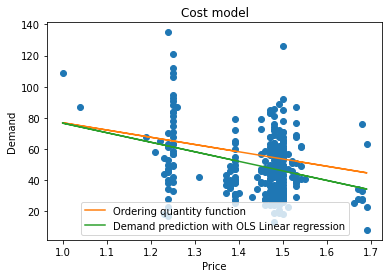

In [63]:
# perform the first step: ordering quantity estimation
D = np.array(train.loc[train['UPC'] == 1111009477, 'UNITS'])
p = np.array(train.loc[train['UPC'] == 1111009477, 'PRICE'])
p=p.reshape(-1,1)

n = len(D)
c = 0.3*np.mean(test.loc[test['UPC'] == 1111009477, 'BASE_PRICE']) #cost per unit 

objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')

# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

In [64]:
# perform the second step: optimal price and quantity optimization
optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, 
                                                     estimationModel = 'cost', nonStockOut = None, 
                                                     priceUpperBound = max(p))


Ordering quantity parameters: 123.53333333333333 -46.666666666666664
Basic approach: 56.161149420650595 1.5501227106227107 51.194273504273525
Data-driven approach: 38.770655455970015 1.4222471476248673 56.6284664441729 



To evaluate the out-of-sample performance, we have to estimate the true demand at the optimal price p and calculate the expected single-period profit. We will assume that this estimation can be obtained by OLS regression over the whole period (2009 - 2011).

In [65]:
testD = np.array(test.loc[test['UPC'] == 1111009477, 'UNITS'])
testp = np.array(test.loc[test['UPC'] == 1111009477, 'PRICE'])
testp = testp.reshape(-1,1)

# do regression over the whole period
reg = linear_model.LinearRegression().fit(testp, testD)
coef2 = reg.coef_
coef1 = reg.intercept_

#estimated demand at optimal price found from each approach
outSampleD = coef1 + coef2 * optP #basic approach
outSampleDDD = coef1 + coef2 * optPDD #data-driven approach

#expected single-period profit
profitD = optP*min(outSampleD, optQ) - c*optQ #basic approach
profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD #DD approach

print(profitD, profitDDD)

[46.30255589] [47.10040582]


Finally, we will do the same process with all available products in the data set to compare the performance of both approaches in each product. Additionally, for each product we also consider the R square score to get the idea of how well the demand of this product can be explained by the linear relationship with price. The purpose is to see in which case each approach will perform better than the other.

In [68]:

productSet = list(set(test.UPC))
caseResult = pd.DataFrame(index = range(len(productSet)), columns = ['Product', 'R square','In-sample Profit (Basic)', 
                                                                    'In-sample Profit (DD)', 'Out-of-sample Profit (Basic)',
                                                                   'Out-of-sample Profit (DD)'])
idx = 0
products = []
for product in productSet:
    print(product)

    D = np.array(train.loc[train['UPC'] == product, 'UNITS'])
    p = np.array(train.loc[train['UPC'] == product, 'PRICE'])
    p=p.reshape(-1,1)

    n = len(D)
    c = 0.3*np.mean(test.loc[test['UPC'] == product, 'BASE_PRICE'])

    objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)

    reg = linear_model.LinearRegression().fit(p, D)
    coef2 = reg.coef_
    coef1 = reg.intercept_

    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', 
                                                         nonStockOut = None, priceUpperBound = max(p))


    testD = np.array(test.loc[test['UPC'] == product, 'UNITS'])
    testp = np.array(test.loc[test['UPC'] == product, 'PRICE'])
    testp = testp.reshape(-1,1)

    testReg = linear_model.LinearRegression().fit(testp, testD)
    testCoef2 = testReg.coef_
    testCoef1 = testReg.intercept_
    Rsquare = testReg.score(testp, testD)

    outSampleD = coef1 + coef2 * optP
    outSampleDDD = coef1 + coef2 * optPDD

    profitD = optP*min(outSampleD, optQ) - c*optQ
    profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD

    caseResult.iloc[idx,:] = [product, Rsquare, optV, optVDD, profitD, profitDDD]
    idx+=1

    products.append(product)
print(caseResult)

1111038080

Ordering quantity parameters: 7.476510067114095 -1.3422818791946316
Basic approach: 8.48013345845538 3.0564965831435065 3.3738300897402587
Data-driven approach: 5.720400652000403 3.1487740847423424 5.8942629735002345 

1111035398

Ordering quantity parameters: 3.0 0.0
Basic approach: [10.52263271] [4.49] [3.]
Data-driven approach: [10.52263271] [4.49] [3.] 

1111085319

Ordering quantity parameters: 74.1818181818182 -27.27272727272728
Basic approach: 31.875148614598142 1.6389100642398287 29.484270975277415
Data-driven approach: 21.5445584163012 1.5055243688216031 31.212971759410742 

1600027527

Ordering quantity parameters: 216.2689075630252 -55.46218487394958
Basic approach: 123.55439852523043 2.4068379953379955 82.78041370394311
Data-driven approach: 94.30294960665846 2.2887219748429337 86.55827702551738 

1600027528

Ordering quantity parameters: 168.29 -31.0
Basic approach: 126.54206320704522 3.408313172043011 62.632291666666646
Data-driven approach: 105.07578361574758

Data-driven approach: 65.31867704855313 2.5092862377532654 53.28569775515972 

7110410455

Ordering quantity parameters: 10.166666666666664 -2.083333333333332
Basic approach: 9.046438505657372 2.796183673469389 4.341284013605443
Data-driven approach: 4.801530629741289 2.403839339995328 5.158668041676365 

1111009497

Ordering quantity parameters: 110.77777777777777 -44.44444444444444
Basic approach: 46.2022299382716 1.4729166666666667 45.31481481481481
Data-driven approach: 33.177297878660916 1.370198514620538 49.43562157242121 

3800031838

Ordering quantity parameters: 204.425 -57.50000000000001
Basic approach: 100.15086960785864 2.2354620147099897 75.88593415417557
Data-driven approach: 71.96969349009507 2.10458869743494 77.53614989749033 

1111009507

Ordering quantity parameters: -10.249999999999982 24.99999999999999
Basic approach: [39.59530621] [1.69] [32.]
Data-driven approach: [39.59530621] [1.69] [32.] 

7110410470

Ordering quantity parameters: 9.975 -2.5
Basic approach: 6.6

In [69]:
selectResult = caseResult.loc[caseResult["In-sample Profit (DD)"] != 0].dropna()

In [70]:
print(selectResult)

        Product    R square In-sample Profit (Basic) In-sample Profit (DD)  \
0    1111038080    0.198979                  8.48013                5.7204   
1    1111035398   0.0103532       [10.5226327077748]    [10.5226327077748]   
2    1111085319  0.00592924                  31.8751               21.5446   
3    1600027527    0.487013                  123.554               94.3029   
4    1600027528    0.710852                  126.542               105.076   
5   88491201426     0.26359                  66.1289               48.6539   
6   88491201427    0.361828                  59.0442               47.8461   
7    2840002333    0.296178                  22.3261               17.7735   
8    2840004768    0.525963                  29.9047               23.4809   
9    1111085345   0.0476638                  41.1926                30.591   
10   2840004770    0.410398                  18.1139               14.0784   
11   1111087395    0.221553                   27.321            

There are 26 products that the performance of Data-driven approach is better than Basic approach in terms of Out-of-sample profit in this specific case study. It is noticeable that most of products that DD approach performs better have relatively lower R square compared to the products that Basic approach performs better. It may indicate that DD approach is more robust than Basic approach in case that the relationship between demand and price is not captured well by the linear regression function.